In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from scipy.stats import skew, kurtosis

torch.cuda.empty_cache()
# imports of custom blocks for model, data generation
from Ferret.ImplicitAm import ImplicitAmBre, ImplicitAmBer
from create_plots import *
from models import *
from utils import AmericanCallData, get_prices_call
from utils import S, T, K, RISK_FREE, SIGMA, S_MAX

## Call Option

### Content: 
1. **Generating Data**
2. **Training on Generated Data, Testing Both on Generated and Real Data**
3. **Training on Real Data, Testing on Real Data**
4. **Mixture of Data (70/30, 50/50), Testing on Real Data**


In [ ]:
call_data = AmericanCallData(t_range=T, S_range=S, K=K, r=RISK_FREE, sigma=SIGMA)
# N_ivp - IVP points
# N_bvp - both BVP1 and BVP2 points
# N_col - colocation points
X = call_data.initialize_data(N_ivp=1000, N_bvp=3000, N_col=6000, is_call=True)
option = ImplicitAmBer(
    S[0],
    K,
    RISK_FREE,
    T[1],
    SIGMA,
    S_MAX,
    M=400,  # S
    N=365 * 3,  # t
    is_call=False,
)
option.price()
option_fde_prices = option.grid
data = get_prices_call(X, option_fde_prices, generated=True)
df = pd.DataFrame(
    data=data,
    columns=[
        "TimeToExp",
        "UnderlyingPrice",
        "TargetPrice",
        "OpenInterest",
        "Delta",
        "Gamma",
        "Theta",
        "Vega",
        "BSAprox",
    ],
)
df[["TimeToExp", "UnderlyingPrice", "TargetPrice", "BSAprox"]] = df[
    ["TimeToExp", "UnderlyingPrice", "TargetPrice", "BSAprox"]
].round(2)
df["OpenInterest"] = df["OpenInterest"].round(0)
df.to_csv("../train_data/generated_call.csv")

In [2]:
df = pd.read_csv("../train_data/generated_call.csv",index_col=0)
print(df.shape)
df.head()

(10000, 9)


,TimeToExp,UnderlyingPrice,TargetPrice,OpenInterest,Delta,Gamma,Theta,Vega,BSAprox
0,850.0,122.12,43.00,364.0,0.345992,0.144298,-3.575622,2.522842,31.500
1,311.0,186.19,29.31,514.0,0.167115,0.056784,-2.531811,6.822075,24.655
2,629.0,52.52,69.69,65.0,0.376269,0.272558,-7.814967,5.852912,0.000
3,469.0,144.80,37.75,58.0,0.009575,0.017516,-1.451383,1.604901,0.000
4,0.0,187.07,29.12,91.0,0.441506,0.138325,-8.777276,5.934998,118.970


In [3]:
# Check for ITM and OTM
print(f"ITM count:{np.sum(df.UnderlyingPrice > K)}")
print(f"OTM count:{np.sum(df.UnderlyingPrice <= K)}")

ITM count:4201
OTM count:5799


In [4]:
df_real = pd.read_csv("../train_data/call_df.csv", index_col=0)
print(df_real.shape)
# Check for ITM and OTM
print(f"ITM count:{np.sum(df_real.UnderlyingPrice > K)}")
print(f"OTM count:{np.sum(df_real.UnderlyingPrice <= K)}")

(223217, 11)
ITM count:57430
OTM count:165787


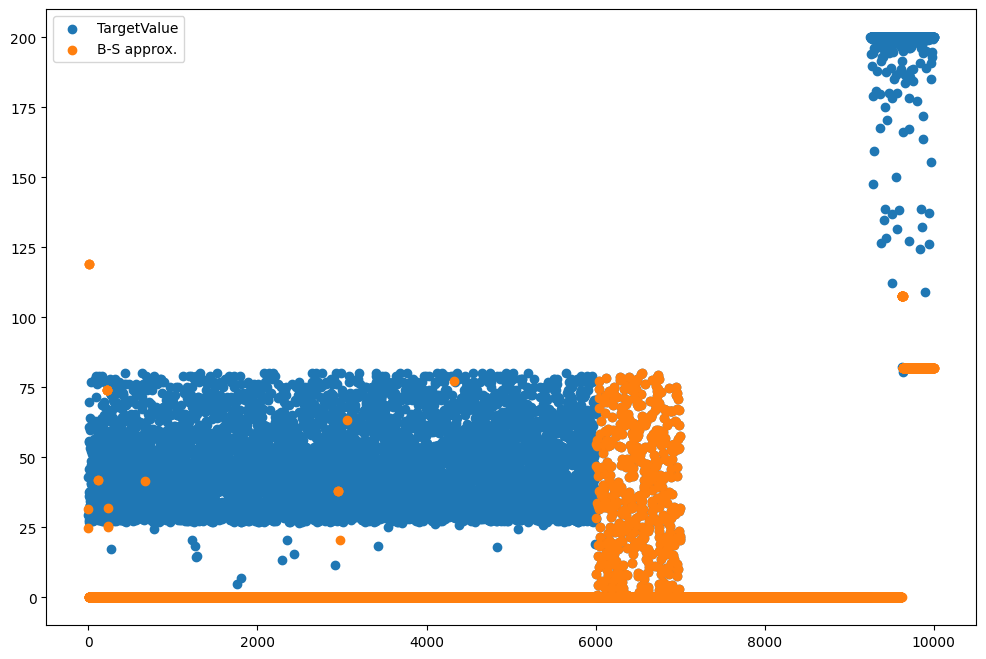

In [30]:
plt.figure(figsize=(12, 8))
plt.scatter(
    x=np.arange(1, len(df.TargetPrice) + 1, 1), y=df.TargetPrice, label="TargetValue"
)
plt.scatter(x=np.arange(1, len(df.BSAprox) + 1, 1), y=df.BSAprox, label="B-S approx.")
plt.legend()
plt.show()

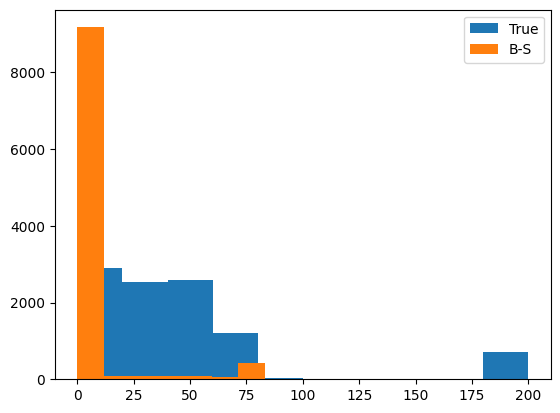

In [5]:
plt.hist(df.TargetPrice, label="Target value")
plt.hist(df.BSAprox, label="B-S")
plt.legend()
plt.show()

In [ ]:
# adding BSAprox column to real data
# Run it once, only if u dont have saved df
df_real = get_prices_call(df_real.to_numpy(), generated=False)
df_real = pd.DataFrame(
    data=df_real,
    columns=[
        [
            "UnderlyingPrice",
            "Type",
            "Strike",
            "OpenInterest",
            "IV",
            "Delta",
            "Gamma",
            "Theta",
            "Vega",
            "Time",
            "TargetPrice",
            "BSAprox",
        ]
    ],
)

df_real["BSAprox"] = df_real["BSAprox"].round(2)
df_real.to_csv("../train_data/call_df_with_approx.csv")

In [2]:
# df_real["BSAprox"] = df_real["BSAprox"].round(2)
# df_real.to_csv("../train_data/call_df_with_approx.csv")
df_real = pd.read_csv("../train_data/call_df_with_approx.csv", index_col=0)
df_real.head()

,UnderlyingPrice,Type,Strike,OpenInterest,IV,Delta,Gamma,Theta,Vega,Time,TargetPrice,BSAprox
0,71.11,call,55.0,0,0.2693,1.0000,0.0000,-1.2654,0.0015,21,16.08,16.11
1,71.11,call,60.0,3,0.2693,0.9968,0.0022,-1.7664,0.1636,21,11.38,11.11
2,71.11,call,62.5,9,0.2693,0.9813,0.0101,-3.2537,0.7659,21,8.50,8.61
3,71.11,call,65.0,16,0.2693,0.9286,0.0302,-6.9022,2.2884,21,6.98,6.11
4,71.11,call,67.5,44,0.2430,0.8313,0.0617,-10.4813,4.2260,21,4.10,3.61


In [3]:
# hyperparams for training
N_EPOCH = 20
RISK_FREE = 0.03
SIGMA = 0.4
LEARNING_RATE = 5e-4
HIDDEN_LAYER = 20
HIDDEN_WIDTH = 64
EXPERIMENT_NAME = "exp_call_8"
MODEL_TYPE = AmericanPut_gated3
experiment_dir = f"../experiments_dir/{EXPERIMENT_NAME}"
os.makedirs(experiment_dir, exist_ok=True)

In [4]:
import logging
from datetime import datetime

logger = logging.getLogger()
current_date = datetime.now().strftime("%Y-%m-%d")
log_file_name = f"{experiment_dir}/{EXPERIMENT_NAME}_log_{current_date}.log"
fhandler = logging.FileHandler(filename=log_file_name, mode="w")
formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.INFO)

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
# torch.set_default_device(DEVICE)
logging.info(f"Running on device={DEVICE}")

cuda


In [6]:
logging.info(f"N_EPOCH: {N_EPOCH}")
logging.info(f"LEARNING_RATE: {LEARNING_RATE}")
logging.info(f"HIDDEN_LAYER: {HIDDEN_LAYER}")
logging.info(f"HIDDEN_WIDTH: {HIDDEN_WIDTH}")
# logging.info(f"N_sample: {N_sample}")
logging.info(f"EXPERIMENT_NAME: {EXPERIMENT_NAME}")
logging.info(f"Model type: {MODEL_TYPE.__name__}")

In [7]:
df = df_real.sample(n=20000, random_state=42)
df_train, df_val = train_test_split(df, test_size=0.3)
print(df_train.shape)
print(df_val.shape)

(14000, 12)
(6000, 12)


In [8]:
initial_mse_train = (
    1 / len(df_train) * np.sum((df_train.TargetPrice - df_train.BSAprox) ** 2)
)
initial_mse_val = 1 / len(df_val) * np.sum((df_val.TargetPrice - df_val.BSAprox) ** 2)
logging.info(
    f"Initial MSE train: {initial_mse_train.round(4)}, Initial MSE val: {initial_mse_val.round(4)}"
)

In [9]:
train_df = CustomDataset(df_train)
val_df = CustomDataset(df_val)

In [10]:
# import torch.multiprocessing as mp
from torch.optim.lr_scheduler import ReduceLROnPlateau

# # Set the multiprocessing start method to 'spawn'
# mp.set_start_method("spawn", force=True)
model = MODEL_TYPE(5, 1, HIDDEN_WIDTH, HIDDEN_LAYER).to(DEVICE)
logging.info(
    f"Total number of learnable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)
train_dataloader = DataLoader(
    train_df,
    batch_size=128,
    shuffle=True,
    num_workers=8,
    # generator=torch.Generator(device=DEVICE),
)
val_dataloader = DataLoader(
    val_df,
    batch_size=64,
    shuffle=False,
    num_workers=8,
)
optimizers_list = {
    "SGD": torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.7),
    "RMSprop": torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE),
    "Adam": torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
    "Adamax": torch.optim.Adamax(
        model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.99)
    ),
}
criteriation = nn.MSELoss()

In [11]:
def train_model(model, train_dataloader, optimizer, scheduler, criteriation, device):
    model.train()
    train_losses = []
    for batch_idx, data in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    ):
        optimizer.zero_grad()
        inputs = data["input"].to(device)
        outputs = data["output"].to(device).view(-1, 1)
        pred = model(inputs).view(-1, 1)
        loss = criteriation(outputs, pred)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    scheduler.step(np.mean(train_losses))  # Step the scheduler based on training loss
    return np.mean(train_losses)


def validate_model(model, val_dataloader, criteriation, device):
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch_idx, data in tqdm(
            enumerate(val_dataloader), total=len(val_dataloader)
        ):
            inputs = data["input"].to(device)
            outputs = data["output"].to(device).view(-1, 1)
            pred = model(inputs).view(-1, 1)
            loss = criteriation(outputs, pred)
            val_losses.append(loss.item())
    return np.mean(val_losses)


def train_cycle(optimizer_name, optimizer, train_loss_dict, val_loss_dict, final=False):
    print(f"Optimizer: {optimizer_name}")
    train_loss_dict[optimizer_name] = []
    val_loss_dict[optimizer_name] = []
    logging.info(f"Optimizer: {optimizer_name}")

    # Define the ReduceLROnPlateau scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=5, verbose=True)

    for i in range(N_EPOCH):
        train_loss = train_model(
            model, train_dataloader, optimizer, scheduler, criteriation, DEVICE
        )
        train_loss_dict[optimizer_name].append(train_loss)
        val_loss = validate_model(model, val_dataloader, criteriation, DEVICE)
        val_loss_dict[optimizer_name].append(val_loss)
        if final:
            torch.save(
                model.state_dict(), f"{experiment_dir}/{EXPERIMENT_NAME}_{i}.pth"
            )
        print(f"Epoch {i+1}, train loss: {train_loss:.4f}, test loss: {val_loss:.4f}")
        logging.info(
            f"Epoch {i+1}, train loss: {train_loss:.4f}, test loss: {val_loss:.4f}"
        )

In [12]:
train_loss_dict = {}
val_loss_dict = {}
for name, optimizer in optimizers_list.items():
    train_cycle(name, optimizer, train_loss_dict, val_loss_dict)

Optimizer: SGD


100%|██████████| 94/94 [00:00<00:00, 319.28it/s]

Epoch 1, train loss: 41.5938, test loss: 29.1397



100%|██████████| 94/94 [00:00<00:00, 295.63it/s]

Epoch 2, train loss: 41.1166, test loss: 32.9078



100%|██████████| 94/94 [00:00<00:00, 289.02it/s]

Epoch 3, train loss: 40.1308, test loss: 28.0935



100%|██████████| 94/94 [00:00<00:00, 318.37it/s]

Epoch 4, train loss: 39.6559, test loss: 27.9840



100%|██████████| 94/94 [00:00<00:00, 246.10it/s]

Epoch 5, train loss: 39.7070, test loss: 27.7568



100%|██████████| 94/94 [00:00<00:00, 275.99it/s]

Epoch 6, train loss: 39.6480, test loss: 28.2033



100%|██████████| 94/94 [00:00<00:00, 326.82it/s]

Epoch 7, train loss: 39.4389, test loss: 28.1420



100%|██████████| 94/94 [00:00<00:00, 323.26it/s]

Epoch 8, train loss: 40.4727, test loss: 29.1892



100%|██████████| 94/94 [00:00<00:00, 309.02it/s]

Epoch 9, train loss: 39.5610, test loss: 28.3378



100%|██████████| 94/94 [00:00<00:00, 334.54it/s]

Epoch 10, train loss: 39.2173, test loss: 28.5830



100%|██████████| 94/94 [00:00<00:00, 326.02it/s]

Epoch 11, train loss: 39.2281, test loss: 27.9072



100%|██████████| 94/94 [00:00<00:00, 323.01it/s]

Epoch 12, train loss: 38.9920, test loss: 27.7232



100%|██████████| 94/94 [00:00<00:00, 322.34it/s]

Epoch 13, train loss: 39.6662, test loss: 27.8691



100%|██████████| 94/94 [00:00<00:00, 315.88it/s]

Epoch 14, train loss: 39.0099, test loss: 27.3773



100%|██████████| 94/94 [00:00<00:00, 327.10it/s]

Epoch 15, train loss: 39.3765, test loss: 27.9925



100%|██████████| 94/94 [00:00<00:00, 332.43it/s]

Epoch 16, train loss: 39.9290, test loss: 28.6191



100%|██████████| 94/94 [00:00<00:00, 328.31it/s]

Epoch 17, train loss: 39.6187, test loss: 29.5461



100%|██████████| 110/110 [00:00<00:00, 149.08it/s]

Epoch 00018: reducing learning rate of group 0 to 5.0000e-05.



100%|██████████| 94/94 [00:00<00:00, 314.36it/s]


Epoch 18, train loss: 39.0393, test loss: 28.0515


100%|██████████| 94/94 [00:00<00:00, 312.68it/s]


Epoch 19, train loss: 39.2474, test loss: 27.6183


100%|██████████| 94/94 [00:00<00:00, 329.67it/s]

Epoch 20, train loss: 38.4708, test loss: 27.7467
Optimizer: RMSprop



100%|██████████| 94/94 [00:00<00:00, 232.39it/s]

Epoch 1, train loss: 41.3513, test loss: 28.9663



100%|██████████| 94/94 [00:00<00:00, 275.81it/s]

Epoch 2, train loss: 40.4259, test loss: 32.3762



100%|██████████| 94/94 [00:00<00:00, 325.05it/s]

Epoch 3, train loss: 39.4865, test loss: 27.7677



100%|██████████| 94/94 [00:00<00:00, 304.64it/s]

Epoch 4, train loss: 39.3091, test loss: 27.8594



100%|██████████| 94/94 [00:00<00:00, 323.60it/s]

Epoch 5, train loss: 39.3271, test loss: 27.4742



100%|██████████| 94/94 [00:00<00:00, 343.89it/s]

Epoch 6, train loss: 38.9850, test loss: 27.6562



100%|██████████| 94/94 [00:00<00:00, 328.24it/s]

Epoch 7, train loss: 39.0136, test loss: 35.6595



100%|██████████| 94/94 [00:00<00:00, 315.54it/s]

Epoch 8, train loss: 41.0850, test loss: 34.1798



100%|██████████| 94/94 [00:00<00:00, 347.98it/s]

Epoch 9, train loss: 38.9014, test loss: 27.3921



100%|██████████| 94/94 [00:00<00:00, 312.12it/s]


Epoch 10, train loss: 38.7457, test loss: 27.6903


100%|██████████| 94/94 [00:00<00:00, 327.62it/s]

Epoch 11, train loss: 39.0181, test loss: 27.5480



100%|██████████| 94/94 [00:00<00:00, 321.72it/s]

Epoch 12, train loss: 38.7968, test loss: 29.8155



100%|██████████| 94/94 [00:00<00:00, 338.90it/s]

Epoch 13, train loss: 38.9781, test loss: 27.4804



100%|██████████| 94/94 [00:00<00:00, 341.71it/s]

Epoch 14, train loss: 38.4966, test loss: 27.9414



100%|██████████| 94/94 [00:00<00:00, 316.33it/s]

Epoch 15, train loss: 38.8943, test loss: 27.4832



100%|██████████| 94/94 [00:00<00:00, 334.46it/s]

Epoch 16, train loss: 38.7075, test loss: 26.8752



100%|██████████| 94/94 [00:00<00:00, 316.82it/s]

Epoch 17, train loss: 38.8870, test loss: 29.1037



100%|██████████| 94/94 [00:00<00:00, 331.34it/s]

Epoch 18, train loss: 38.7254, test loss: 27.3210



100%|██████████| 94/94 [00:00<00:00, 312.77it/s]


Epoch 19, train loss: 38.7413, test loss: 27.4811


100%|██████████| 110/110 [00:00<00:00, 141.67it/s]

Epoch 00020: reducing learning rate of group 0 to 5.0000e-05.



100%|██████████| 94/94 [00:00<00:00, 308.98it/s]

Epoch 20, train loss: 38.5703, test loss: 27.4584
Optimizer: Adam



100%|██████████| 94/94 [00:00<00:00, 322.73it/s]

Epoch 1, train loss: 39.3864, test loss: 27.5877



100%|██████████| 94/94 [00:00<00:00, 327.08it/s]

Epoch 2, train loss: 38.7050, test loss: 27.5133



100%|██████████| 94/94 [00:00<00:00, 333.32it/s]

Epoch 3, train loss: 39.7001, test loss: 27.6596



100%|██████████| 94/94 [00:00<00:00, 318.80it/s]

Epoch 4, train loss: 38.5771, test loss: 28.1609



100%|██████████| 94/94 [00:00<00:00, 320.09it/s]

Epoch 5, train loss: 38.3790, test loss: 29.0534



100%|██████████| 94/94 [00:00<00:00, 313.14it/s]


Epoch 6, train loss: 38.4739, test loss: 28.6826


100%|██████████| 94/94 [00:00<00:00, 329.06it/s]

Epoch 7, train loss: 38.2517, test loss: 27.7512



100%|██████████| 94/94 [00:00<00:00, 280.36it/s]

Epoch 8, train loss: 38.5983, test loss: 27.8358



100%|██████████| 94/94 [00:00<00:00, 323.79it/s]

Epoch 9, train loss: 38.9688, test loss: 27.8919



100%|██████████| 94/94 [00:00<00:00, 296.32it/s]

Epoch 10, train loss: 38.9768, test loss: 28.4107



100%|██████████| 94/94 [00:00<00:00, 331.83it/s]

Epoch 11, train loss: 38.4947, test loss: 28.1014



100%|██████████| 94/94 [00:00<00:00, 349.88it/s]

Epoch 12, train loss: 38.6344, test loss: 27.1567



100%|██████████| 110/110 [00:00<00:00, 136.84it/s]

Epoch 00013: reducing learning rate of group 0 to 5.0000e-05.



100%|██████████| 94/94 [00:00<00:00, 302.46it/s]

Epoch 13, train loss: 38.2923, test loss: 28.4200



100%|██████████| 94/94 [00:00<00:00, 321.42it/s]

Epoch 14, train loss: 38.0201, test loss: 28.2401



100%|██████████| 94/94 [00:00<00:00, 314.26it/s]


Epoch 15, train loss: 38.3144, test loss: 28.2810


100%|██████████| 94/94 [00:00<00:00, 318.45it/s]

Epoch 16, train loss: 37.7511, test loss: 28.4020



100%|██████████| 94/94 [00:00<00:00, 331.66it/s]

Epoch 17, train loss: 37.7029, test loss: 28.1483



100%|██████████| 94/94 [00:00<00:00, 234.49it/s]

Epoch 18, train loss: 38.2253, test loss: 28.4526



100%|██████████| 94/94 [00:00<00:00, 308.79it/s]

Epoch 19, train loss: 39.6733, test loss: 28.8574



100%|██████████| 94/94 [00:00<00:00, 341.02it/s]

Epoch 20, train loss: 38.3404, test loss: 28.7494
Optimizer: Adamax



100%|██████████| 94/94 [00:00<00:00, 325.41it/s]

Epoch 1, train loss: 38.5579, test loss: 28.4750



100%|██████████| 94/94 [00:00<00:00, 331.66it/s]

Epoch 2, train loss: 37.6707, test loss: 28.8455



100%|██████████| 94/94 [00:00<00:00, 324.80it/s]

Epoch 3, train loss: 37.5308, test loss: 29.0301



100%|██████████| 94/94 [00:00<00:00, 330.93it/s]

Epoch 4, train loss: 37.4649, test loss: 29.1963



100%|██████████| 94/94 [00:00<00:00, 311.93it/s]

Epoch 5, train loss: 37.4039, test loss: 30.0711



100%|██████████| 94/94 [00:00<00:00, 337.25it/s]

Epoch 6, train loss: 37.5787, test loss: 29.0482



100%|██████████| 94/94 [00:00<00:00, 327.05it/s]

Epoch 7, train loss: 38.6343, test loss: 29.2701



100%|██████████| 94/94 [00:00<00:00, 285.99it/s]

Epoch 8, train loss: 37.2887, test loss: 29.9556



100%|██████████| 94/94 [00:00<00:00, 323.02it/s]

Epoch 9, train loss: 37.3471, test loss: 29.4373



100%|██████████| 94/94 [00:00<00:00, 333.31it/s]

Epoch 10, train loss: 38.4515, test loss: 29.2331



100%|██████████| 94/94 [00:00<00:00, 324.09it/s]

Epoch 11, train loss: 37.4647, test loss: 28.5968



100%|██████████| 94/94 [00:00<00:00, 337.04it/s]

Epoch 12, train loss: 37.6535, test loss: 29.0718



100%|██████████| 94/94 [00:00<00:00, 318.24it/s]

Epoch 13, train loss: 37.3332, test loss: 28.9318



100%|██████████| 110/110 [00:01<00:00, 93.54it/s]

Epoch 00014: reducing learning rate of group 0 to 5.0000e-05.



100%|██████████| 94/94 [00:00<00:00, 294.38it/s]

Epoch 14, train loss: 37.3103, test loss: 28.7760



100%|██████████| 94/94 [00:00<00:00, 302.17it/s]

Epoch 15, train loss: 36.9133, test loss: 28.9347



100%|██████████| 94/94 [00:00<00:00, 302.04it/s]

Epoch 16, train loss: 36.7781, test loss: 28.9139



100%|██████████| 94/94 [00:00<00:00, 299.34it/s]

Epoch 17, train loss: 36.7863, test loss: 28.9799



100%|██████████| 94/94 [00:00<00:00, 331.77it/s]

Epoch 18, train loss: 36.7537, test loss: 29.0246



100%|██████████| 94/94 [00:00<00:00, 314.83it/s]

Epoch 19, train loss: 36.7312, test loss: 29.0313



100%|██████████| 94/94 [00:00<00:00, 332.25it/s]

Epoch 20, train loss: 36.7301, test loss: 29.0949


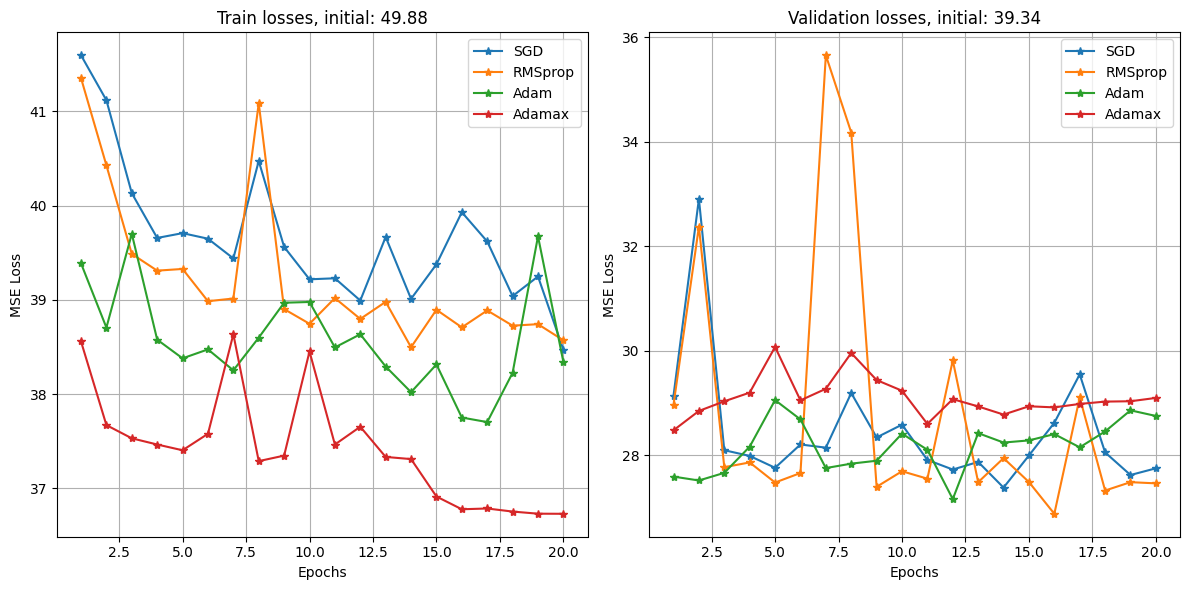

In [13]:
# Plot
plot_dictionaries(
    train_loss_dict,
    val_loss_dict,
    initial_mse_train,
    initial_mse_val,
    f"{experiment_dir}/{EXPERIMENT_NAME}_testing.png",
)

### So for full training we will take SGD, 20 layers with 256 neurouns in each and lr=4e-7

In [18]:
N_EPOCH = 200
RISK_FREE = 0.03
SIGMA = 0.4
LEARNING_RATE = 1e-5
HIDDEN_LAYER = 20
HIDDEN_WIDTH = 64
# EXPERIMENT_NAME = "exp_call_8_final"
# MODEL_TYPE = AmericanPut_gated3
# experiment_dir = f"../experiments_dir/{EXPERIMENT_NAME}"
# os.makedirs(experiment_dir, exist_ok=True)

In [19]:
logging.info(f"N_EPOCH: {N_EPOCH}")
logging.info(f"LEARNING_RATE: {LEARNING_RATE}")
logging.info(f"HIDDEN_LAYER: {HIDDEN_LAYER}")
logging.info(f"HIDDEN_WIDTH: {HIDDEN_WIDTH}")
# logging.info(f"N_sample: {N_sample}")
logging.info(f"EXPERIMENT_NAME: {EXPERIMENT_NAME}")
logging.info(f"Model type: {MODEL_TYPE.__name__}")

In [20]:
df_train, df_test = train_test_split(df_real, test_size=0.2)
logging.info(f"train set size: {df_train.shape}")
logging.info(f"test set size: {df_test.shape}")
initial_mse_train = (
    1 / len(df_train) * np.sum((df_train.TargetPrice - df_train.BSAprox) ** 2)
)
initial_mse_val = (
    1 / len(df_test) * np.sum((df_test.TargetPrice - df_test.BSAprox) ** 2)
)
logging.info(
    f"Initial MSE train: {initial_mse_train.round(4)}, Initial MSE val: {initial_mse_val.round(4)}"
)
train_df = CustomDataset(df_train)
test_df = CustomDataset(df_test)

In [21]:
# import torch.multiprocessing as mp
from torch.optim.lr_scheduler import ReduceLROnPlateau

# # Set the multiprocessing start method to 'spawn'
# mp.set_start_method("spawn", force=True)
model = MODEL_TYPE(5, 1, HIDDEN_WIDTH, HIDDEN_LAYER).to(DEVICE)
logging.info(
    f"Total number of learnable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)
train_dataloader = DataLoader(
    train_df,
    batch_size=64,
    shuffle=True,
    num_workers=8,
    # generator=torch.Generator(device=DEVICE),
)
val_dataloader = DataLoader(
    test_df,
    batch_size=64,
    shuffle=False,
    num_workers=8,
)
optimizers_list = {
    "SGD": torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.7),
}
# criteriation = nn.MSELoss()
# # Set the multiprocessing start method to 'spawn'
# mp.set_start_method("spawn", force=True)
# model = MODEL_TYPE(5, 1, HIDDEN_WIDTH, HIDDEN_LAYER).to(DEVICE)

In [22]:
train_loss_dict = {}
test_loss_dict = {}
train_cycle("SGD", optimizers_list["SGD"], train_loss_dict, test_loss_dict)

Optimizer: SGD


100%|██████████| 698/698 [00:02<00:00, 330.93it/s]

Epoch 1, train loss: 33.0939, test loss: 27.6716



100%|██████████| 698/698 [00:02<00:00, 325.48it/s]

Epoch 2, train loss: 32.1951, test loss: 27.3362



100%|██████████| 698/698 [00:02<00:00, 323.31it/s]

Epoch 3, train loss: 32.0366, test loss: 27.2788



100%|██████████| 698/698 [00:01<00:00, 364.89it/s]

Epoch 4, train loss: 31.9045, test loss: 27.3631



100%|██████████| 698/698 [00:01<00:00, 364.18it/s]

Epoch 5, train loss: 31.8064, test loss: 27.4780



100%|██████████| 698/698 [00:01<00:00, 352.01it/s]

Epoch 6, train loss: 31.7667, test loss: 27.3083



100%|██████████| 698/698 [00:01<00:00, 353.02it/s]

Epoch 7, train loss: 31.7094, test loss: 26.9861



100%|██████████| 698/698 [00:02<00:00, 346.47it/s]

Epoch 8, train loss: 31.6693, test loss: 27.6177



100%|██████████| 698/698 [00:02<00:00, 326.18it/s]


Epoch 9, train loss: 31.6511, test loss: 27.1612


100%|██████████| 698/698 [00:01<00:00, 357.62it/s]

Epoch 10, train loss: 31.5914, test loss: 26.9207



100%|██████████| 698/698 [00:01<00:00, 370.32it/s]

Epoch 11, train loss: 31.5514, test loss: 27.0975



100%|██████████| 698/698 [00:01<00:00, 365.48it/s]

Epoch 12, train loss: 31.5193, test loss: 27.0320



100%|██████████| 698/698 [00:02<00:00, 314.95it/s]

Epoch 13, train loss: 31.5004, test loss: 26.7964



100%|██████████| 698/698 [00:01<00:00, 353.35it/s]

Epoch 14, train loss: 31.4672, test loss: 27.1693



100%|██████████| 698/698 [00:01<00:00, 357.21it/s]

Epoch 15, train loss: 31.4207, test loss: 27.1450



100%|██████████| 698/698 [00:01<00:00, 355.00it/s]

Epoch 16, train loss: 31.4213, test loss: 26.7146



100%|██████████| 698/698 [00:01<00:00, 350.03it/s]

Epoch 17, train loss: 31.3742, test loss: 26.8277



100%|██████████| 698/698 [00:01<00:00, 357.08it/s]

Epoch 18, train loss: 31.3470, test loss: 26.7623



100%|██████████| 698/698 [00:01<00:00, 362.98it/s]

Epoch 19, train loss: 31.3256, test loss: 26.7790



100%|██████████| 698/698 [00:01<00:00, 356.09it/s]

Epoch 20, train loss: 31.2945, test loss: 26.5694



100%|██████████| 698/698 [00:01<00:00, 356.36it/s]

Epoch 21, train loss: 31.2812, test loss: 26.6440



100%|██████████| 698/698 [00:01<00:00, 363.52it/s]

Epoch 22, train loss: 31.2434, test loss: 26.6613



100%|██████████| 698/698 [00:01<00:00, 354.40it/s]

Epoch 23, train loss: 31.2328, test loss: 26.7018



100%|██████████| 698/698 [00:02<00:00, 339.93it/s]

Epoch 24, train loss: 31.1828, test loss: 26.8560



100%|██████████| 698/698 [00:02<00:00, 318.86it/s]

Epoch 25, train loss: 31.1759, test loss: 27.0841



100%|██████████| 698/698 [00:02<00:00, 342.89it/s]

Epoch 26, train loss: 31.1396, test loss: 26.5536



100%|██████████| 698/698 [00:02<00:00, 322.26it/s]

Epoch 27, train loss: 31.1260, test loss: 26.6489



100%|██████████| 698/698 [00:02<00:00, 288.66it/s]

Epoch 28, train loss: 31.1003, test loss: 26.5728



100%|██████████| 698/698 [00:01<00:00, 359.08it/s]

Epoch 29, train loss: 31.0685, test loss: 26.9215



100%|██████████| 698/698 [00:02<00:00, 280.72it/s]

Epoch 30, train loss: 31.0612, test loss: 26.4499



100%|██████████| 698/698 [00:02<00:00, 341.53it/s]

Epoch 31, train loss: 31.0210, test loss: 26.4698



100%|██████████| 698/698 [00:01<00:00, 350.09it/s]

Epoch 32, train loss: 31.0125, test loss: 26.6007



100%|██████████| 698/698 [00:02<00:00, 335.62it/s]

Epoch 33, train loss: 30.9691, test loss: 26.9178



100%|██████████| 698/698 [00:02<00:00, 347.26it/s]

Epoch 34, train loss: 30.9309, test loss: 26.8231



100%|██████████| 698/698 [00:02<00:00, 338.72it/s]

Epoch 35, train loss: 30.9244, test loss: 26.4093



100%|██████████| 698/698 [00:02<00:00, 337.17it/s]

Epoch 36, train loss: 30.9072, test loss: 26.3110



100%|██████████| 698/698 [00:02<00:00, 298.72it/s]

Epoch 37, train loss: 30.8654, test loss: 26.4878



100%|██████████| 698/698 [00:02<00:00, 339.40it/s]

Epoch 38, train loss: 30.8507, test loss: 26.5988



100%|██████████| 698/698 [00:01<00:00, 370.53it/s]

Epoch 39, train loss: 30.8375, test loss: 26.4377



100%|██████████| 698/698 [00:02<00:00, 326.76it/s]

Epoch 40, train loss: 30.8234, test loss: 26.3189



100%|██████████| 698/698 [00:02<00:00, 305.04it/s]

Epoch 41, train loss: 30.7918, test loss: 26.1958



100%|██████████| 698/698 [00:02<00:00, 340.68it/s]

Epoch 42, train loss: 30.7392, test loss: 26.4204



100%|██████████| 698/698 [00:02<00:00, 343.80it/s]

Epoch 43, train loss: 30.7455, test loss: 26.2925



100%|██████████| 698/698 [00:02<00:00, 331.95it/s]

Epoch 44, train loss: 30.7242, test loss: 26.2970



100%|██████████| 698/698 [00:02<00:00, 345.41it/s]

Epoch 45, train loss: 30.7184, test loss: 26.9404



100%|██████████| 698/698 [00:02<00:00, 342.86it/s]

Epoch 46, train loss: 30.7221, test loss: 26.1738



100%|██████████| 698/698 [00:02<00:00, 347.07it/s]

Epoch 47, train loss: 30.6441, test loss: 26.2383



100%|██████████| 698/698 [00:02<00:00, 326.92it/s]

Epoch 48, train loss: 30.6680, test loss: 26.7371



100%|██████████| 698/698 [00:02<00:00, 345.74it/s]

Epoch 49, train loss: 30.8094, test loss: 26.3002



100%|██████████| 698/698 [00:02<00:00, 335.36it/s]

Epoch 50, train loss: 30.6445, test loss: 26.4567



 50%|█████     | 1405/2791 [00:09<00:09, 146.54it/s]


KeyboardInterrupt: 

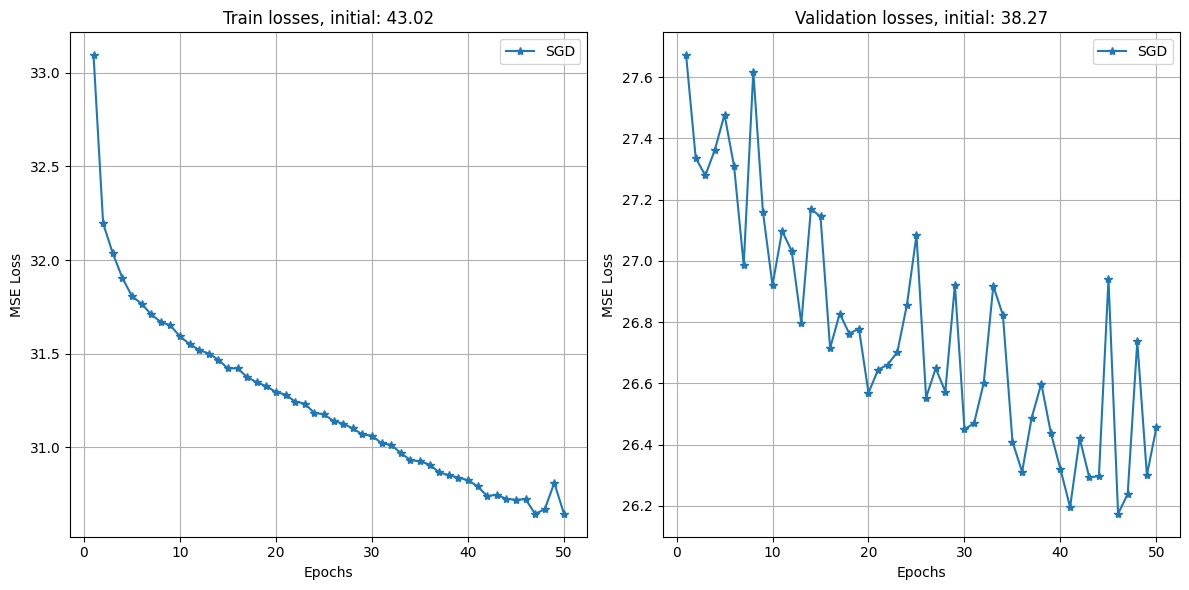

In [23]:
plot_dictionaries(
    train_loss_dict,
    test_loss_dict,
    initial_mse_train,
    initial_mse_val,
    f"{experiment_dir}/{EXPERIMENT_NAME}_final.png",
)

In [24]:
import json

file_path = f"{experiment_dir}/{EXPERIMENT_NAME}_train.json"
with open(file_path, "w") as json_file:
    json.dump(train_loss_dict, json_file)

file_path = f"{experiment_dir}/{EXPERIMENT_NAME}_test.json"
with open(file_path, "w") as json_file:
    json.dump(test_loss_dict, json_file)

In [25]:
logging.info(
    f"% of variation before training: {(initial_mse_train/(df_train.TargetPrice - df_train.BSAprox).var() * 100).round(2)}"
)
logging.info(
    f"% of variation after training: {(train_loss_dict['SGD'][46]/ (df_train.TargetPrice - df_train.BSAprox).var() * 100).round(2)}"
)
logging.info(
    f"% of variation before training: {(initial_mse_val/(df_test.TargetPrice - df_test.BSAprox).var() * 100).round(2)}"
)
logging.info(
    f"% of variation after training: {(test_loss_dict['SGD'][46] / (df_test.TargetPrice - df_test.BSAprox).var() * 100).round(2)}"
)